# Build and test some models

In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.figure as fig
import seaborn as sns
import sql_utils
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import RidgeCV
from sklearn import metrics
from sklearn import preprocessing
from sklearn.ensemble import RandomForestRegressor
import pickle
import time
%matplotlib inline

In [140]:
# plot in seaborn style
sns.set(font_scale=1.35, style="whitegrid")

In [109]:
# store the figure path for easy plotting to file
figpath = '/Users/bkhurley/git/insight/project/beat_the_crowd/figures/'

## Pull the data from postgres

In [2]:
# select and join the BART and weather data from postgres
bart_weather_df = sql_utils.pg2pd_join(table1='bart_entry_exit', table2='weather',
                           on1='bart_entry_exit.date', on2='weather.datestamp')

In [3]:
bart_weather_df.head()

,id,date,hour,direction,station,entries,exits,day,month,id,datestamp,mean_temperature,max_temperature,min_temperature,precipitation,rain
0,0,2011-01-01,0,northbound,12TH,16,102,Saturday,1,0,2011-01-01,43.0,45.0,40.0,0.36,1
1,1,2011-01-01,0,northbound,16TH,168,26,Saturday,1,0,2011-01-01,43.0,45.0,40.0,0.36,1
2,2,2011-01-01,0,northbound,19TH,19,91,Saturday,1,0,2011-01-01,43.0,45.0,40.0,0.36,1
3,3,2011-01-01,0,northbound,24TH,72,32,Saturday,1,0,2011-01-01,43.0,45.0,40.0,0.36,1
4,4,2011-01-01,0,northbound,BALB,72,5,Saturday,1,0,2011-01-01,43.0,45.0,40.0,0.36,1


In [4]:
# remove the redundant 'id' and 'datestamp' columns
bart_weather_df.drop(labels=['id', 'datestamp'], axis=1, inplace=True)
bart_weather_df.head()

,date,hour,direction,station,entries,exits,day,month,mean_temperature,max_temperature,min_temperature,precipitation,rain
0,2011-01-01,0,northbound,12TH,16,102,Saturday,1,43.0,45.0,40.0,0.36,1
1,2011-01-01,0,northbound,16TH,168,26,Saturday,1,43.0,45.0,40.0,0.36,1
2,2011-01-01,0,northbound,19TH,19,91,Saturday,1,43.0,45.0,40.0,0.36,1
3,2011-01-01,0,northbound,24TH,72,32,Saturday,1,43.0,45.0,40.0,0.36,1
4,2011-01-01,0,northbound,BALB,72,5,Saturday,1,43.0,45.0,40.0,0.36,1


-------
## Transform features before feeding to model
Generate some new features, and transform categorical features to binary dummy variables 

In [5]:
# take a look at the current data types
bart_weather_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2126069 entries, 0 to 2126068
Data columns (total 13 columns):
date                object
hour                object
direction           object
station             object
entries             int64
exits               int64
day                 object
month               object
mean_temperature    float64
max_temperature     float64
min_temperature     float64
precipitation       float64
rain                int64
dtypes: float64(4), int64(3), object(6)
memory usage: 210.9+ MB


In [6]:
# restrict to only the columns to be used in the models
model_data = bart_weather_df[['hour', 'direction', 'station', 'entries', 
                              'day','month', 'max_temperature', 'rain']]
# remove NaN from data before training
model_data = model_data.loc[(~model_data.isnull().any(axis=1)), :]

 ### Transform categorical features to binary dummy variables

In [7]:
# create a weekday dummy variable
model_data['weekday'] = 0
model_data.loc[model_data['day'].isin([
    'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday']), 'weekday'] = 1

In [8]:
# transform direction to binary dummy
model_data['northbound'] = 0
model_data.loc[model_data['direction'] == 'northbound', 'northbound'] = 1
# drop the original categorical feature
model_data.drop('direction', axis=1, inplace=True)

In [9]:
model_data.head()

,hour,station,entries,day,month,max_temperature,rain,weekday,northbound
0,0,12TH,16,Saturday,1,45.0,1,0,1
1,0,16TH,168,Saturday,1,45.0,1,0,1
2,0,19TH,19,Saturday,1,45.0,1,0,1
3,0,24TH,72,Saturday,1,45.0,1,0,1
4,0,BALB,72,Saturday,1,45.0,1,0,1


In [10]:
# transform categorical features into binary dummy variables
model_data_binary = pd.get_dummies(model_data)

In [11]:
model_data_binary.head()

,entries,max_temperature,rain,weekday,northbound,hour_0,hour_1,hour_10,hour_11,hour_12,...,month_11,month_12,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9
0,16,45.0,1,0,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,168,45.0,1,0,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,19,45.0,1,0,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,72,45.0,1,0,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,72,45.0,1,0,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


-------
# Linear Regression
Train regression models to predict passenger crowding using the above features. 

## Least-squares regression
First, use a simple *ordinary least-squares (OLS) regression* model

#### Partition data for validation
Partition into 80% training set and 20% test set. 

In [12]:
X = model_data_binary.drop('entries', axis=1) # features = all columns except 'entries'
y = model_data_binary['entries']

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

### Train model
Fit an OLS regression model to the training data

In [250]:
lm = LinearRegression()
lm.fit(X_train,y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

### Evaluate model predictions

In [251]:
figpath = '/Users/bkhurley/git/insight/project/beat_the_crowd/figures/'

In [252]:
predictions = lm.predict(X_test)

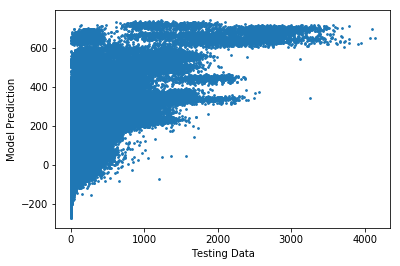

In [253]:
plt.scatter(y_test, predictions, s=3)
plt.xlabel('Testing Data')
plt.ylabel('Model Prediction')
plt.savefig(figpath + 'ols_predict.png')

Looks like the OLS model is pretty biased. This is likely due to the extreme outliers of the high-volume stations at high-volume times (e.g., downtown SF stations at rushour).

### Evaluate model

In [254]:
print('RSS: ', sum((y_test - predictions)**2))
print('MAE:', metrics.mean_absolute_error(y_test, predictions))
print('MSE:', metrics.mean_squared_error(y_test, predictions))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, predictions)))
print('R^2: ', metrics.r2_score(y_test, predictions))

RSS:  28938547159.113773
MAE: 154.935119327
MSE: 68056.4307833
RMSE: 260.876274857
R^2:  0.289005124996


#### Residuals

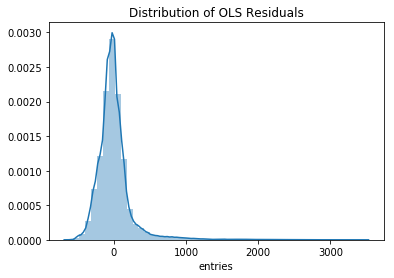

In [210]:
sns.distplot((y_test-predictions),bins=50);
plt.title('Distribution of OLS Residuals')
plt.savefig(figpath + 'ols_resid.png')

In [167]:
# dump model to pickle file so I can pick it up in Flask
with open('lm.pkl', 'wb') as fid:
    pickle.dump(lm, fid,2) 

In [168]:
#For building feature vectors, create a dataframe with the dummy variables
feats = model_data_binary.drop('entries', axis=1)
index_dict = dict(zip(feats.columns,range(feats.shape[1])))
with open('cat.pkl', 'wb') as fid:
    pickle.dump(index_dict, fid,2) 

## Ridge Regression
OLS did not perform very good. With the one-hot encoding of multi-class categoricals, we ended up with 70+ features. This might lead to an over-fitting to the training data. Let's use a ridge regression to impart some regularization and shrink the less informative features.

### Train model
Fit ridge model under each tuning value, and select best penalty (`alpha`) using cross-validation.  

In [192]:
# define array of tuning values to test
tuning = np.logspace(0, 7, num=15)
# fit ridge model to data using 10-fold CV
ridge = RidgeCV(alphas=tuning, cv=10)

In [193]:
# start timer
start = time.time()

ridge.fit(X, y)

# end timer
end = time.time()
elapsed = end-start
print(str(elapsed/60) + ' minutes elapsed' )

34.65736091931661 minutes elapsed


In [194]:
print('Optimal tuning parameter value: ', ridge.alpha_)

Optimal tuning parameter value:  1000.0


### Evaluate model predictions

In [195]:
ridge_predictions = ridge.predict(X)

In [196]:
print('MSE:', metrics.mean_squared_error(y, ridge_predictions))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y, ridge_predictions)))
print('R^2: ', ridge.score(X, y))

MSE: 67967.7997637
RMSE: 260.706347763
R^2:  0.288578701692


No improvement in model fit compared to the simple OLS regression. Predictions are still pretty biased, as shown below. Perhaps a polynomial model would improve things.

Text(0,0.5,'Ridge-Predicted Crowd Levels')

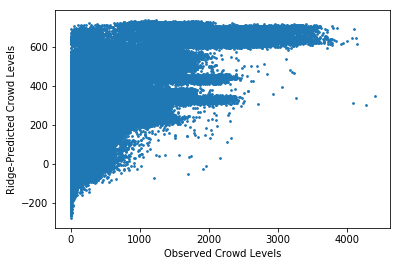

In [198]:
plt.scatter(y, ridge_predictions, s=3)
plt.xlabel('Observed Crowd Levels')
plt.ylabel('Ridge-Predicted Crowd Levels')

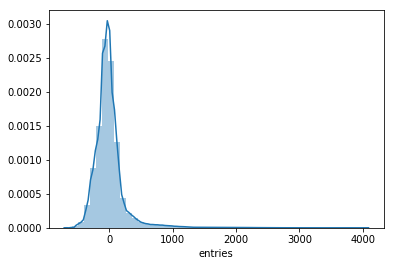

In [199]:
sns.distplot((y-ridge_predictions),bins=50)

## Random Forest Regression

In [15]:
regr = RandomForestRegressor(random_state=0)

In [17]:
# time the fit
t0 = time.time()

In [18]:
regr.fit(X, y)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=0, verbose=0, warm_start=False)

In [ ]:
rf_fit = time.time() - t0
print("RF model fitted in %.3f s"
      % rf_fit)

### Evaluate model predictions

In [25]:
# get model predictions
rfreg_pred = regr.predict(X)

In [34]:
print('MSE:', metrics.mean_squared_error(y, rfreg_pred))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y, rfreg_pred)))
print('R^2: ', metrics.r2_score(y, rfreg_pred))

MSE: 2382.45042711
RMSE: 48.8103516389
R^2:  0.97506280942


Compare these model metrics to the earlier OLS and Ridge regression models. <br>
We see that that the fit with a Random Forest regression is *phenomenally* better.<br>
Explaining 97.5% of the variance!

Text(0,0.5,'Random Forest Prediction')

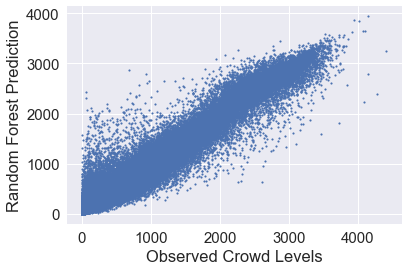

In [89]:
# compare predictions to observed values
plt.scatter(y, rfreg_pred, s=3)
plt.xlabel('Observed Crowd Levels')
plt.ylabel('Random Forest Prediction')

Text(0.5,1,'Residual Error')

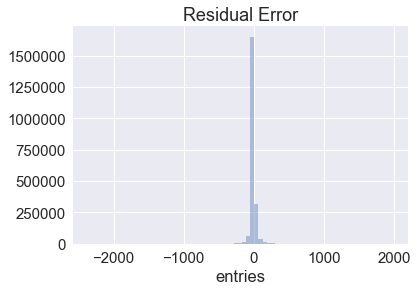

In [102]:
# check out the distribution of residuals
sns.distplot((y-rfreg_pred),bins=75, kde=False)
plt.title('Residual Error')

We can see from the two above plots that model predictions tightly correspond to the observed data, and prediction error is no longer highly skewed like in the OLS and Ridge Regression models.

### Feature Importance

In [46]:
importances = regr.feature_importances_

In [70]:
std = np.std([regr.feature_importances_ for tree in regr.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]
sorted_featnames = X.columns[indices]

In [72]:
# Print the feature ranking
print("Feature ranking:")
for f in np.arange(X.shape[1]):
    print("%d. %s (%f)" % (f + 1, sorted_featnames[f], importances[indices[f]]))

Feature ranking:
1. weekday (0.150134)
2. hour_17 (0.132916)
3. hour_18 (0.106738)
4. northbound (0.081146)
5. station_POWL (0.039331)
6. station_MONT (0.037727)
7. station_EMBR (0.036720)
8. hour_16 (0.035541)
9. max_temperature (0.032682)
10. hour_8 (0.030033)
11. hour_19 (0.024590)
12. station_GLEN (0.018020)
13. station_DALY (0.017504)
14. station_PHIL (0.016041)
15. station_CIVC (0.015050)
16. hour_7 (0.012886)
17. hour_9 (0.011624)
18. station_24TH (0.010874)
19. station_BALB (0.010256)
20. hour_15 (0.010156)
21. station_16TH (0.009199)
22. station_WCRK (0.008356)
23. station_COLM (0.008228)
24. station_CONC (0.007940)
25. station_12TH (0.007727)
26. station_19TH (0.007635)
27. station_WOAK (0.007350)
28. hour_20 (0.007057)
29. station_MCAR (0.006657)
30. station_SSAN (0.005171)
31. station_ROCK (0.005168)
32. hour_21 (0.004870)
33. day_Friday (0.004699)
34. hour_14 (0.004108)
35. hour_10 (0.004086)
36. station_SBRN (0.004078)
37. hour_6 (0.003801)
38. station_LAFY (0.003688)
39.

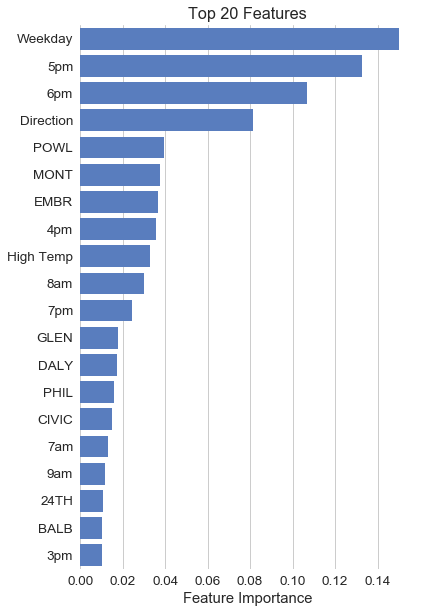

In [141]:
# Plot ranked feature importance
f, ax = plt.subplots(figsize=(6, 10))
sns.set_color_codes("muted")
featimport = sns.barplot(importances[indices[0:20]], sorted_featnames[0:20],
                         color='b')
featimport.set_yticklabels(['Weekday', '5pm', '6pm', 'Direction', 'POWL', 'MONT',
                            'EMBR', '4pm', 'High Temp', '8am', '7pm', 'GLEN',
                            'DALY', 'PHIL', 'CIVIC', '7am', '9am', '24TH', 
                            'BALB', '3pm'])

plt.title('Top 20 Features')
ax.set(xlabel="Feature Importance")
sns.despine(left=True, bottom=True)
plt.savefig(figpath + 'randforest_featimport.png', bbox_inches='tight')


Pickle the model so I can use it to make predictions in m Flask app

In [105]:
# pickle the model for web deployment in Flask
with open('rf_reg.pkl', 'wb') as fid:
    pickle.dump(regr, fid,2) 

In [107]:
#For building feature vectors, create a dataframe with the dummy variables
index_dict = dict(zip(X.columns,range(X.shape[1])))
with open('cat.pkl', 'wb') as fid:
    pickle.dump(index_dict, fid,2) 